<a href="https://colab.research.google.com/github/taravatp/roadLane_InstanceSegmentation/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [ ]:
cd drive/MyDrive/Lane_Detection/

/content/drive/MyDrive/Lane_Detection


In [ ]:
!pip install import_ipynb 
!pip install ujson

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=3908fc4fcd2f0c7150d514026c8b83af9093a4ed94e1739e232104ce578d5f1a
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
     |████████████████████████████████| 178 kB 5.2 MB/s 


In [ ]:
import json
import os.path as ops
import numpy as np
import torch
import cv2
import time 
import os
import matplotlib.pylab as plt
import sys
import import_ipynb

from tqdm import tqdm
from dataset.dataset_Lanenet import TUSIMPLE
from models.model1_TuSimple import Lanenet
from models.ENet_SAD_modified import Enet_SAD

importing Jupyter notebook from /content/drive/MyDrive/Lane_Detection/dataset/dataset_Lanenet.ipynb
363
importing Jupyter notebook from /content/drive/My Drive/Lane_Detection/models/model1_TuSimple.ipynb
importing Jupyter notebook from /content/drive/My Drive/Lane_Detection/models/ENet_SAD_modified.ipynb
salam


# Loading model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = '/content/drive/MyDrive/Lane_Detection/mymodel5_batch_16.pth'

test_model = Enet_SAD(2,4).to(device)
test_model.load_state_dict(torch.load(model_path))
print('model loaded!')

model loaded!


In [ ]:
print(device)

cuda


# test on sample image

In [ ]:
  test_image_path = '/content/drive/MyDrive/Lane_Detection/test12.jpg'
  gt_test_image = cv2.imread(test_image_path, cv2.IMREAD_UNCHANGED)
  org_shape = gt_test_image.shape
  gt_test_image = cv2.resize(gt_test_image, dsize=(512,256), interpolation=cv2.INTER_LINEAR)
  gt_test_image = gt_test_image / 127.5 - 1.0
  gt_test_image = np.transpose(gt_test_image, (2, 0, 1))
  gt_test_image = torch.tensor(gt_test_image, dtype=torch.float)
  gt_test_image = gt_test_image.unsqueeze(0).to(device) #we add one more diension which is for batch size

  forward_start = time.time() #start of feedforward
  binary_preds, instance_embedding_preds = test_model(gt_test_image)
  forward_end = time.time() #end of feedforward

  binary_preds = torch.argmax(binary_preds, dim=1).squeeze().cpu().numpy()
  binary_preds[0:50,:] = 0

  cluster_start = time.time()
  rgb_emb, cluster_result = process_instance_embedding(instance_embedding_preds.cpu(), binary_preds, distance=1.5, lane_num=4)
  cluster_end = time.time()

  cluster_result = cv2.resize(cluster_result, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_NEAREST)

AttributeError: ignored

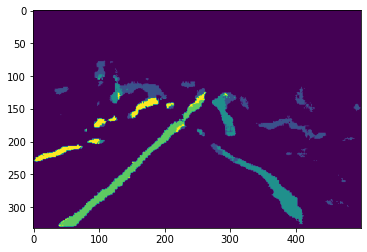

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cluster_result)

# Enumerate through all test images and save predictions

In [ ]:
json_pred_path = '/content/drive/MyDrive/Lane_Detection/TUSMIPLE/test_set/test_tasks_0627.json'
json_pred = [json.loads(line) for line in open(json_pred_path).readlines()]
print(len(json_pred))

2782


In [ ]:
all_time_forward = []
all_time_clustering = []

In [ ]:

for i,sample in enumerate(json_pred):
  print(i)
  h_samples = sample['h_samples']
  lanes = sample['lanes']
  run_time = sample['run_time']
  raw_file = sample['raw_file']
  test_image_path = ops.join('TUSMIPLE/test_set',raw_file)

  gt_test_image = cv2.imread(test_image_path, cv2.IMREAD_UNCHANGED)
  org_shape = gt_test_image.shape
  gt_test_image = cv2.resize(gt_test_image, dsize=(512,256), interpolation=cv2.INTER_LINEAR)
  gt_test_image = gt_test_image / 127.5 - 1.0
  gt_test_image = np.transpose(gt_test_image, (2, 0, 1))
  gt_test_image = torch.tensor(gt_test_image, dtype=torch.float)
  gt_test_image = gt_test_image.unsqueeze(0).to(device) #we add one more diension which is for batch size

  forward_start = time.time() #start of feedforward
  binary_preds, instance_embedding_preds,loss,at1,at2, at3  = test_model(gt_test_image)
  forward_end = time.time() #end of feedforward

  binary_preds = torch.argmax(binary_preds, dim=1).squeeze().cpu().numpy()
  #binary_img[0:50,:] = 0

  cluster_start = time.time()
  rgb_emb, cluster_result = process_instance_embedding(instance_embedding_preds.cpu(), binary_preds, distance=1.5, lane_num=4)
  cluster_end = time.time()

  cluster_result = cv2.resize(cluster_result, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_NEAREST)
  elements = np.unique(cluster_result)
    
  for line_idx in elements:
    if line_idx == 0:
      continue
    else:
      mask = (cluster_result == line_idx)
      select_mask = mask[h_samples]
      row_result = []
      for row in range(len(h_samples)):
        col_indexes = np.nonzero(select_mask[row])[0]
        if len(col_indexes) == 0:
          row_result.append(-2)
        else:
          row_result.append(int(col_indexes.min() + (col_indexes.max()-col_indexes.min())/2))
            
      json_pred[i]['lanes'].append(row_result)
      json_pred[i]['run_time'] = forward_end-forward_start
      all_time_forward.append(forward_end-forward_start)
      all_time_clustering.append(cluster_end-cluster_start)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
  forward_avg = np.sum(all_time_forward[500:2000])/1500
cluster_avg = np.sum(all_time_clustering[500:2000])/1500

print('The forward pass time for one image is: {}ms'.format(forward_avg*1000))
print('The clustering time for one image is: {}ms'.format(cluster_avg*1000))
print('The total time for one image is: {}ms'.format((cluster_avg+forward_avg)*1000))
print('The speed for forward pass is: {}fps'.format(1/forward_avg))
print('The speed for forward pass is: {}fps'.format(1/cluster_avg))

with open('TUSMIPLE/pred.json', 'w') as f:
    for res in json_pred:
        json.dump(res, f)
        f.write('\n')
        

The forward pass time for one image is: 32.684019247690834ms
The clustering time for one image is: 805.0807361602783ms
The total time for one image is: 837.7647554079691ms
The speed for forward pass is: 30.595992262201694fps
The speed for forward pass is: 1.242111449305522fps


In [ ]:
from utils.lane import LaneEval
result = LaneEval.bench_one_submit('TUSMIPLE/pred.json', 'TUSMIPLE/test_set/test_label.json')
print(result)

[{"name":"Accuracy","value":0.8357034807093208,"order":"desc"},{"name":"FP","value":0.42742032111190986,"order":"asc"},{"name":"FN","value":0.35277378384855124,"order":"asc"}]


# Post-Processing

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def process_instance_embedding(instance_embedding, binary_img, distance=1, lane_num=5):
    #instance-embedding => (1,4,256,512)
    #binary-image => (256,512)
    #print(instance_embedding.shape)

    embedding = instance_embedding[0].detach().numpy().transpose(1, 2, 0)
    cluster_result = np.zeros(binary_img.shape, dtype=np.int32)
    cluster_list = embedding[binary_img > 0] #[8155,4] har seri ke run koni ye adade chon model har seri motefavet kar mikonad
    # outputs = np.unique(cluster_list) #[25012,]
    mean_shift = MeanShift(bandwidth=distance, bin_seeding=True, n_jobs=-1)
    mean_shift.fit(cluster_list)
    labels = mean_shift.labels_
    cluster_result[binary_img > 0] = labels + 1
    cluster_result[cluster_result > lane_num] = 0
    # print(f"cluster_result shape: {cluster_result.shape}")

    for idx in np.unique(cluster_result):
        if len(cluster_result[cluster_result == idx]) < 15:
            cluster_result[cluster_result == idx] = 0
    H, W = binary_img.shape
    rbg_emb = np.zeros((H, W, 3))
    color = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 215, 0], [0, 255, 255]]
    element = np.unique(cluster_result)
    
    for i in range(len(element)):
        rbg_emb[cluster_result == element[i]] = color[i]

    return rbg_emb / 255, cluster_result